# Bayesian Accelerated Randomized Benchmarking

## Standard RB on Simulator

This is a bayesian pyMC3 implementation on top of frequentist standard RB from qiskit experiments

Based on the tutorial "randomized_benchmarking" of qiskit experiments version 0.2.0

The Bayesian sequential Monte Carlo (SMC) algorithms are based on equation 13 in [this paper](https://arxiv.org/abs/1802.00401) by Hincks et al.

This demo shows that accelerated SMC delivers on simulator precise estimations of the error per Clifford, with narrow error bounds.

In [1]:
import numpy as np
import time
import copy
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library.randomized_benchmarking import RBUtils
import qiskit.circuit.library as circuits

# for retrieving gate calibration
from datetime import datetime
import qiskit.providers.aer.noise.device as dv

# import the bayesian packages
import pymc3 as pm
import arviz as az
import qiskit_bayesian_fitter as bf

In [2]:
# for WIP
import importlib
importlib.reload(bf)

<module 'qiskit_bayesian_fitter' from 'C:\\Users\\decpi\\OneDrive\\Documents\\qiskit-tutorials-master\\tutorials\\noise\\qiskit_bayesian_fitter.py'>

In [3]:
simulation = True # make your choice here
if simulation:
    from qiskit.providers.aer import AerSimulator
    from qiskit.test.mock import FakeParis
    backend = AerSimulator.from_backend(FakeParis())
else:
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = provider.get_backend('ibmq_bogota') # type here hardware backend  

## One-qubit standard RB

In [184]:
# describe RB experiment 
qubits = [0]
lengths = np.arange(1, 2500, 250)
num_samples = 10
seed = 1010

### Prepare and run circuits using Qiskit experiments

In [5]:
exp1 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend).block_for_results()
results1 = expdata1.analysis_results()

In [6]:
#prepare circuits
exp1 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
#run
print("start experiments",time.strftime('%d/%m/%Y %H:%M:%S'))
expdata1 = exp1.run(backend).block_for_results()
print("  end experiments",time.strftime('%d/%m/%Y %H:%M:%S'))

start experiments 22/08/2021 14:58:27
  end experiments 22/08/2021 15:01:07


### Least-squares fit using qiskit experiments

In [7]:
#analyse
print("   start analysis",time.strftime('%d/%m/%Y %H:%M:%S'))
results1 = expdata1.analysis_results()
print("     end analysis",time.strftime('%d/%m/%Y %H:%M:%S'))

   start analysis 22/08/2021 15:01:07
     end analysis 22/08/2021 15:01:07


   ### prepare for SMC

In [185]:
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
m_len = len(lengths)
interleaved_gate = "" # for plot title
experiment_type = expdata1._data[0]['metadata']['experiment_type']
physical_qubits = expdata1._data[0]['metadata']['physical_qubits']
shots = expdata1._data[0]['shots']
# to compare ultimately: EPC and sigma(EPC) by LSF
epc_est_fm = expdata1.analysis_results()[2].value.value
epc_est_fm_err = expdata1.analysis_results()[2].value.stderr

In [186]:
# get count data and other values from expdata1
Y = bf.get_GSP_counts(expdata1._data, m_len,
                    range(num_samples))

In [187]:
X = np.copy(lengths)
y_mean = np.mean(Y, axis = 0)/shots
sigma_y = np.std(Y, axis = 0)/shots

###  Serial Monte Carlo, hierarchical model

Model based on equation 13 in [this paper](https://arxiv.org/abs/1802.00401) by Hincks et al.

A good introduction to model creation and inference using PyMC3 can be found here: [General API quickstart — PyMC3 3.11.2 documentation](https://docs.pymc.io/pymc-examples/examples/pymc3_howto/api_quickstart.html).

In [188]:
model = "hierarchical_model"

In [189]:
# priors for unknown model parameters
T_priors = expdata1.analysis_results()[0].value.value
print(T_priors)

[0.47133581 0.99729569 0.51384443]


In [190]:
# building the model
def create_model(T_priors, X, Y, shots, scale,
                testval_s = 0.001, upper_s = 0.0015, lower_s = 0.0005):
    my_model = pm.Model()
    with my_model:

        # Tying parameters
        BoundedUniform = pm.Bound(pm.Uniform,
                                   lower=np.fmax(T_priors-0.1, np.full(T_priors.shape,1.e-9)),
                                   upper=np.fmin(T_priors+0.1, np.full(T_priors.shape,1.-1e-9)))
        pi = BoundedUniform("Tying_Parameters",testval = T_priors, shape = T_priors.shape)
        EPC = pm.Deterministic('EPC', scale*(1-pi[1])) 

        # sigma of Beta functions
        sigma_t = pm.Uniform("σ_Beta",  testval = testval_s,
                                upper = upper_s, lower = lower_s)    

        # Tying function
        GSP = pi[0] * pi[1]**X + pi[2]

        theta = pm.Beta('θ', mu=GSP, sigma = sigma_t,
                         shape = ((len(X), )) )                                 

        # Likelihood (sampling distribution) of observations    
        p = pm.Binomial("Counts", p = theta, observed = Y, n = shots)
    return my_model

In [191]:
h_model = create_model(T_priors, X, Y, shots, scale)

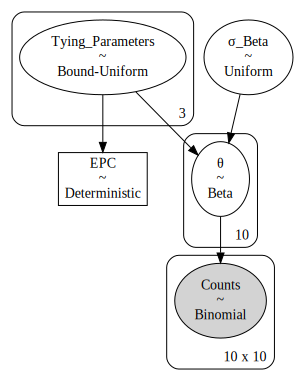

In [192]:
# model graph                                
pm.model_to_graphviz(h_model)

In [193]:
# sample
with h_model:
    trace_h = pm.sample(draws = 4000, tune= 1000, target_accept=.99,
                         return_inferencedata=True)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ_Beta, Tying_Parameters]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 212 seconds.
The number of effective samples is smaller than 25% for some parameters.


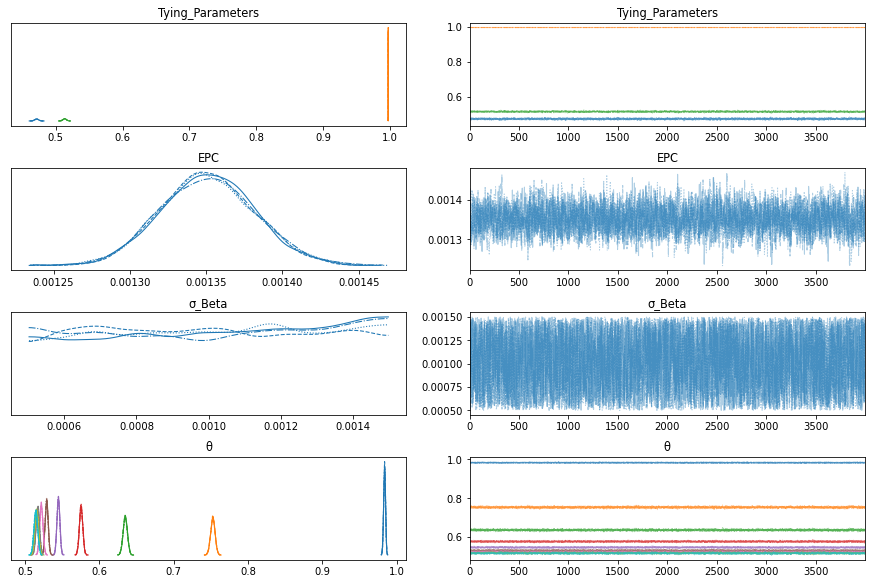

In [194]:
with h_model:
        az.plot_trace(trace_h);

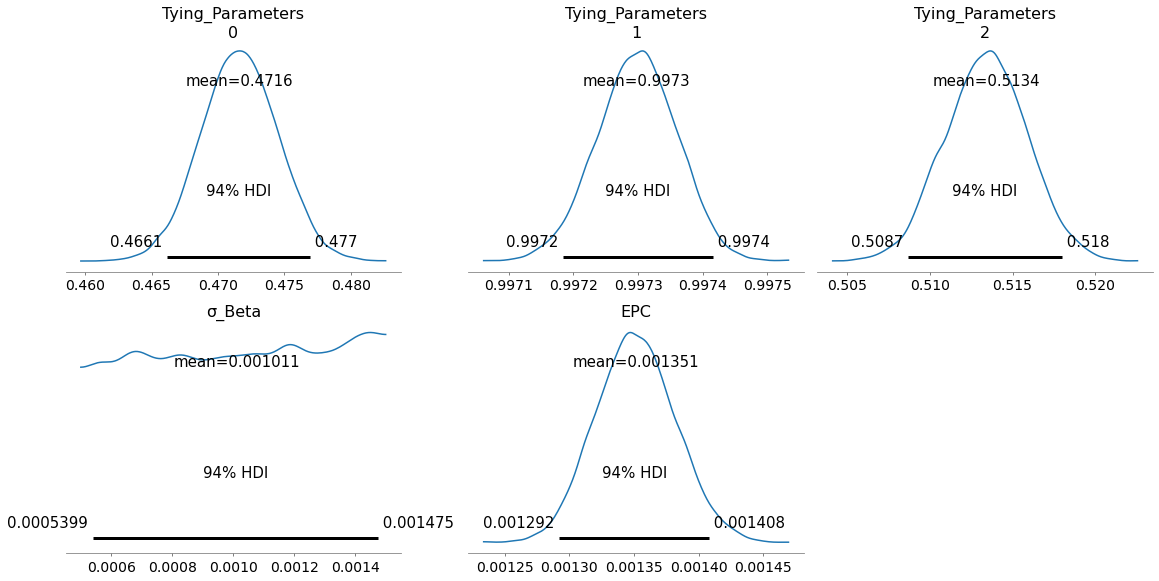

In [195]:
with h_model:
    az.plot_posterior(trace_h, var_names = ["Tying_Parameters","σ_Beta","EPC"], round_to = 4, figsize = [16, 8]);

In [196]:
# look at the posterior values of the hyperparameters:
with h_model:
    #  (hdi_prob=.94 is default)
    azt_summary = az.summary(trace_h, round_to=12,
                            var_names = ["Tying_Parameters", "σ_Beta","EPC"],
                            kind="stats") 
azt_summary

,mean,sd,hdi_3%,hdi_97%
Tying_Parameters[0],0.471623,0.002894,0.466148,0.476959
Tying_Parameters[1],0.997298,0.000062,0.997183,0.997416
Tying_Parameters[2],0.513423,0.002487,0.508697,0.517976
σ_Beta,0.001011,0.000290,0.000540,0.001475
EPC,0.001351,0.000031,0.001292,0.001408


In [197]:
epc_calib = np.nan

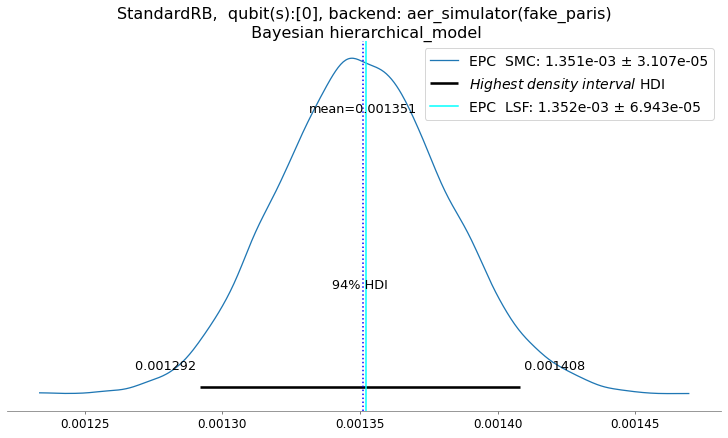

In [198]:
# mean and sigma of EPC
epc_est_a = azt_summary['mean']['EPC']
epc_est_a_err = azt_summary['sd']['EPC']

# plot 
import matplotlib.pyplot as plt # if not yet imported 

with h_model:
    az.plot_posterior(trace_h, var_names = ["EPC"],
                      round_to = 4, figsize = [10,6],
                      textsize = 12) 

Bayes_legend =  "EPC  SMC: {0:1.3e} ± {1:1.3e}"\
                    .format(epc_est_a, epc_est_a_err)
LSF_legend =    "EPC  LSF: {0:1.3e} ± {1:1.3e}".format(epc_est_fm, epc_est_fm_err)  
Cal_legend =    "EPC Calibration: {0:1.3e}".format(epc_calib)
plt.axvline(x=epc_est_fm,color='cyan',ls="-")    
if epc_calib != np.nan:
    plt.axvline(x=epc_calib,color='r',ls=":")
plt.axvline(x=epc_est_a,color='blue',ls=":")
if epc_calib > 0.0:   
    plt.legend((Bayes_legend, "$Highest\; density\; interval$ HDI",
                LSF_legend,
                Cal_legend), fontsize=12 )
else: 
    plt.legend((Bayes_legend, "$Highest\; density\; interval$ HDI",
                LSF_legend))
plt.title(experiment_type +', ' + interleaved_gate  + " qubit(s):" + str(physical_qubits)\
                     +', backend: '+backend.name() + "\n Bayesian "+model,
                     fontsize=16);

In [199]:
# backend's recorded EPG
error_dic = RBUtils.get_error_dict_from_backend(backend, qubits)

# get the EPG values
EPG_dic = {}
REF_dic = {}
for i in range(3,6):
    EPG_key = expdata1.analysis_results()[i].name
    EPG_dic[EPG_key] = expdata1.analysis_results()[i].value.value
    for elem in (error_dic):
        if 'EPG_' + elem[1] == EPG_key:
            REF_dic[EPG_key] = error_dic[elem]      

In [200]:
# compare LSF and SMC

print("Model:    Frequentist         Bayesian      Reference")
print("________________________________________________________")
print("EPC         {0:1.3e}        {1:1.3e}         {2:1.3e}"
      .format(epc_est_fm, epc_est_a, epc_calib ))  
print("± sigma    ± {0:1.3e}      ± {1:1.3e} "
      .format(epc_est_fm_err, epc_est_a_err))

for i, (gate,EPG) in enumerate(EPG_dic.items()):
    print("{0:<12}{1:1.3e}        {2:1.3e}      {3:1.3e} "
      .format(gate, EPG, EPG*epc_est_a/epc_est_fm,
             REF_dic[gate])) 

Model:    Frequentist         Bayesian      Reference
________________________________________________________
EPC         1.352e-03        1.351e-03         nan
± sigma    ± 6.943e-05      ± 3.107e-05 
EPG_rz      0.000e+00        0.000e+00      0.000e+00 
EPG_sx      4.354e-04        4.350e-04      4.432e-04 
EPG_x       4.354e-04        4.350e-04      4.432e-04 


#### routine for computing  the optimized function based on this [document](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html):

In [201]:
def calc_chisquare(ydata, sigma, ycalc): 
    r = ydata - ycalc
    chisq = np.sum((r / sigma) ** 2)
    return chisq

### GSP plot

In [202]:
# prepare box for GSP plot

# perform reduced χ² value calculation for Bayes hierarchical 
mean_h = trace_h.posterior.mean(dim=['chain', 'draw'])
theta_stacked = mean_h.θ.values
NDF_h = m_len*2 - 3 - 1 # (-1 is for σ_Beta)
chisq_h = calc_chisquare(y_mean, sigma_y, theta_stacked)/NDF_h

texto =  "alpha = {0:7.4f} ± {1:1.4e}"\
            .format(azt_summary['mean']['Tying_Parameters[1]'],
            azt_summary['sd']['Tying_Parameters[1]']) + "\n"                                             
                                           
texto += "EPC = {0:1.4e} ± {1:1.4e}"\
            .format(azt_summary['mean']['EPC'],
            azt_summary['sd']['EPC']) + "\n"

for i, (gate,EPG) in enumerate(EPG_dic.items()):
    texto += "   {0:<8} = {1:1.4e}         "\
              .format(gate.ljust(6), EPG*epc_est_a/epc_est_fm) + "\n"               

texto += "             Fit χ² = {0:7.4f} "\
            .format(chisq_h)

In [203]:
# prepare data for GSP plot
# get the calculated GSP values
with h_model:
    hdi_prob = .94
    #  (hdi_prob=.94 is default, roughly corresponding to 2σ)
    theta_summary = az.summary(trace_h, round_to=12, hdi_prob = hdi_prob,
                            var_names = ["θ"], kind="stats")
y1 = theta_summary.values[:,0]

HDI = True # make your choice here
if HDI:
    # HDI values as bounds
    bounds_rmk = "(shown bounds are "+ str(int(100*hdi_prob)) + "% HDI)"
    y1_min = theta_summary.values[:,2]   
    y1_max = theta_summary.values[:,3]
    
else:    
    # two sigma bounds for plot
    bounds_rmk = "(shown bounds are ± two σ)"
    sy = theta_summary.values[:,1]
    y1_min = y1 - sy[0:m_len]*2
    y1_max = y1 + sy[0:m_len]*2

In [204]:
# for WIP
import importlib
importlib.reload(bf)

<module 'qiskit_bayesian_fitter' from 'C:\\Users\\decpi\\OneDrive\\Documents\\qiskit-tutorials-master\\tutorials\\noise\\qiskit_bayesian_fitter.py'>

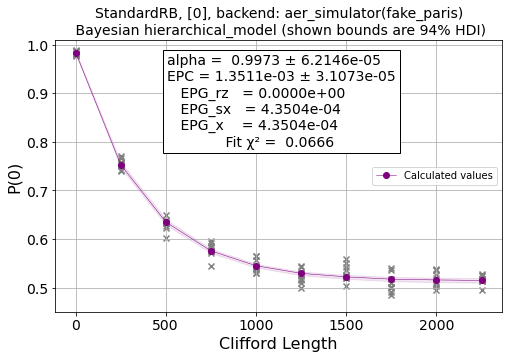

In [205]:
title = experiment_type +', ' + interleaved_gate\
          + str(physical_qubits)\
          +', backend: '+backend.name()+\
          "\n Bayesian "+model+" "+ bounds_rmk
bf.gsp_plot(scale, lengths, num_samples, shots, texto, title,
         y1, y1_min, y1_max, y2=None, y2_min=None, y2_max=None, Y1=Y, Y2=None,
         first_curve = "Calculated values", second_curve = None)

#### compare with frequentist model results

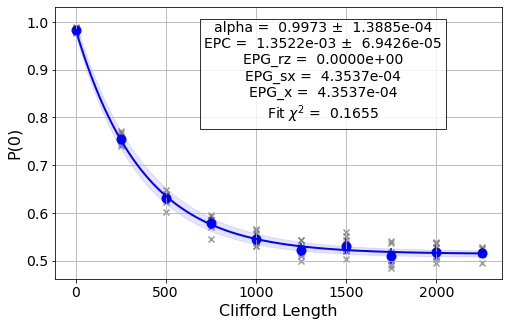

In [206]:
# View result data for frequentist model
display(expdata1.figure(0))

## Two-qubit standard RB

In [113]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = (1,4)

# Run a 1-qubit RB expriment on qubits 1, 4 to determine the error-per-gate of 1-qubit gates
expdata_1q = {}
epg_1q = []
lengths_1_qubit = np.arange(1, 2500, 250)
for qubit in qubits:
    exp = StandardRB([qubit], lengths_1_qubit, num_samples=num_samples, seed=seed)
    expdata = exp.run(backend).block_for_results()
    expdata_1q[qubit] = expdata
    epg_1q += expdata.analysis_results()

In [114]:
# Run an RB experiment on qubits 1, 4
exp2 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)

# Use the EPG data of the 1-qubit runs to ensure correct 2-qubit EPG computation
exp2.set_analysis_options(epg_1_qubit=epg_1q)

# Run the 2-qubit experiment
expdata2 = exp2.run(backend).block_for_results()

# View result data
results2 = expdata2.analysis_results()

In [116]:
# Compare the computed EPG of the cx gate with the backend's recorded cx gate error:
expected_epg = RBUtils.get_error_dict_from_backend(backend, qubits)[(qubits, 'cx')]
exp2_epg = expdata2.analysis_results("EPG_cx").value

print("Backend's reported EPG of the cx gate:", expected_epg)
print("Experiment computed EPG of the cx gate:", exp2_epg)

Backend's reported EPG of the cx gate: 0.012438847900902494
Experiment computed EPG of the cx gate: 0.012006538371817893


# Preamble: 2 x 1-Qubit RB

In [117]:
trace_1q = {}
scale_1q = .5
for qubit in qubits:
    Y = bf.get_GSP_counts(expdata_1q[qubit]._data, len(lengths_1_qubit),
                    range(num_samples))
    X = np.copy(lengths_1_qubit)    
    shots_1_qubit = expdata_1q[qubit]._data[0]['shots']
    T_priors = expdata_1q[qubit].analysis_results()[0].value.value
    h1_model = create_model(T_priors, X, Y, shots_1_qubit, scale_1q)    
    with h1_model:
        trace_h1 = pm.sample(draws = 4000, tune= 1000, target_accept=.99,
                             return_inferencedata=True)
    trace_1q[qubit] = trace_h1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ_Beta, Tying_Parameters]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 264 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ_Beta, Tying_Parameters]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 258 seconds.
The number of effective samples is smaller than 25% for some parameters.


# 2Q BAYES

   ### prepare for SMC

In [118]:
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
m_len = len(lengths)
interleaved_gate = "" # for plot title
experiment_type = expdata2._data[0]['metadata']['experiment_type']
physical_qubits = expdata2._data[0]['metadata']['physical_qubits']
shots = expdata2._data[0]['shots']
# to compare ultimately: EPC and sigma(EPC) by LSF
epc_est_fm = expdata2.analysis_results()[2].value.value
epc_est_fm_err = expdata2.analysis_results()[2].value.stderr

In [119]:
# get count data and other values from expdata2
Y = bf.get_GSP_counts(expdata2._data, m_len,
                    range(num_samples))

In [120]:
X = np.copy(lengths)
y_mean = np.mean(Y, axis = 0)/shots
sigma_y = np.std(Y, axis = 0)/shots

###  Serial Monte Carlo, hierarchical model

Model based on equation 13 in [this paper](https://arxiv.org/abs/1802.00401) by Hincks et al.

A good introduction to model creation and inference using PyMC3 can be found here: [General API quickstart — PyMC3 3.11.2 documentation](https://docs.pymc.io/pymc-examples/examples/pymc3_howto/api_quickstart.html).

In [121]:
model = "hierarchical_model"

In [122]:
# priors for unknown model parameters
T_priors = expdata2.analysis_results()[0].value.value
print(T_priors)

[0.70347215 0.96870351 0.26039206]


In [123]:
h2_model = create_model(T_priors, X, Y, shots, scale)

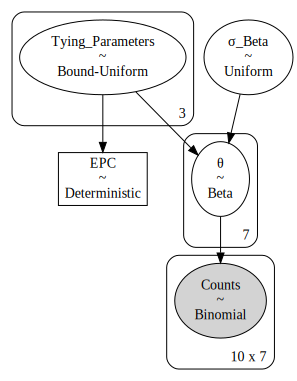

In [124]:
# model graph                                
pm.model_to_graphviz(h2_model)

In [125]:
# sample
with h2_model:
    trace_h2 = pm.sample(draws = 4000, tune= 1000, target_accept=.99,
                         return_inferencedata=True)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ_Beta, Tying_Parameters]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 236 seconds.
The number of effective samples is smaller than 25% for some parameters.


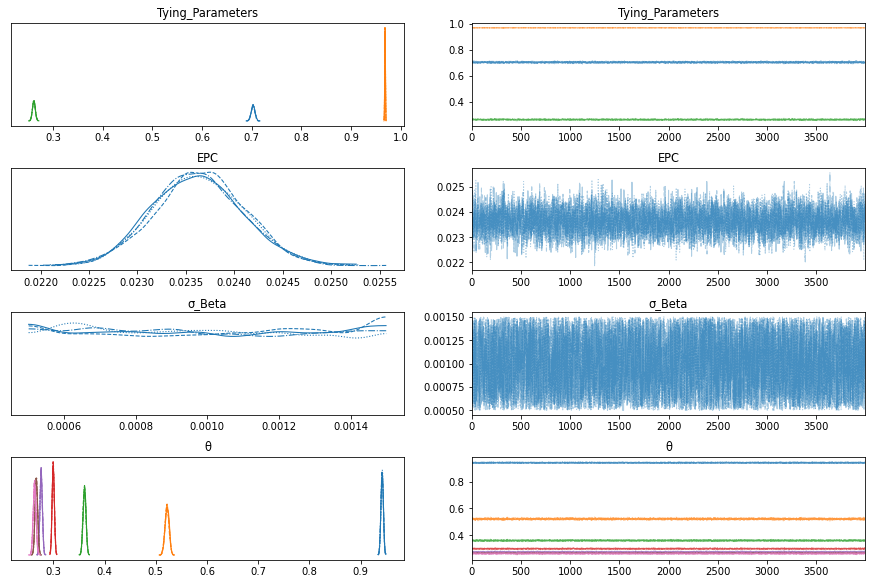

In [126]:
with h2_model:
        az.plot_trace(trace_h2);

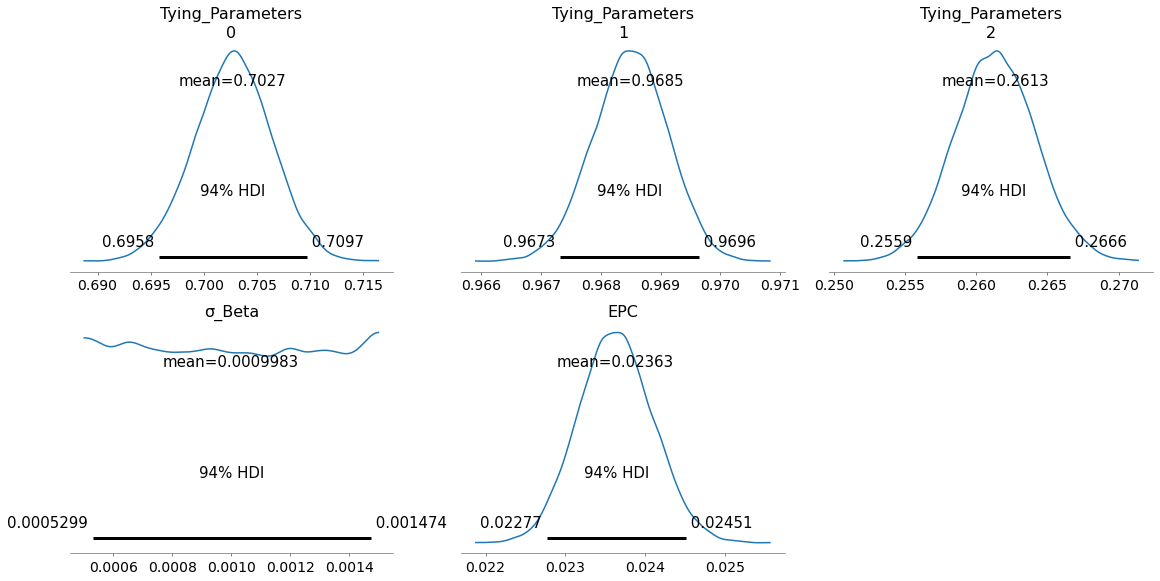

In [127]:
with h2_model:
    az.plot_posterior(trace_h2, var_names = ["Tying_Parameters","σ_Beta","EPC"], round_to = 4, figsize = [16, 8]);

In [128]:
# look at the posterior values of the hyperparameters:
with h2_model:
    #  (hdi_prob=.94 is default)
    azt2_summary = az.summary(trace_h2, round_to=12,
                            var_names = ["Tying_Parameters", "σ_Beta","EPC"],
                            kind="stats") 
azt2_summary

,mean,sd,hdi_3%,hdi_97%
Tying_Parameters[0],0.702705,0.003647,0.695798,0.709654
Tying_Parameters[1],0.968490,0.000623,0.967318,0.969643
Tying_Parameters[2],0.261324,0.002831,0.255862,0.266583
σ_Beta,0.000998,0.000291,0.000530,0.001474
EPC,0.023632,0.000467,0.022768,0.024512


In [129]:
epc_calib = np.nan

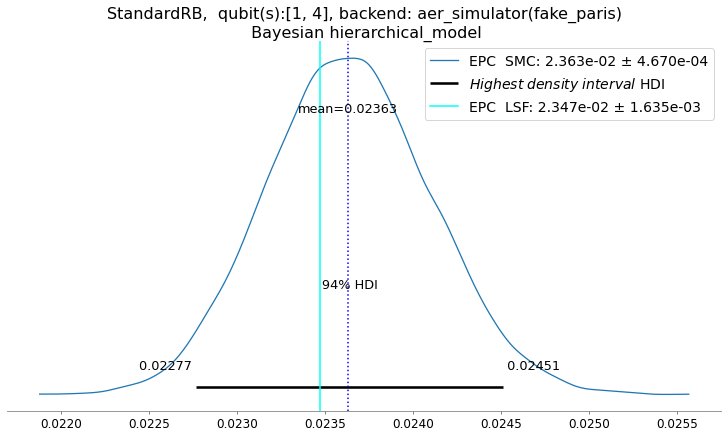

In [130]:
# mean and sigma of EPC
epc_est_a = azt2_summary['mean']['EPC']
epc_est_a_err = azt2_summary['sd']['EPC']

# plot 
import matplotlib.pyplot as plt # if not yet imported 

with h2_model:
    az.plot_posterior(trace_h2, var_names = ["EPC"],
                      round_to = 4, figsize = [10,6],
                      textsize = 12) 

Bayes_legend =  "EPC  SMC: {0:1.3e} ± {1:1.3e}"\
                    .format(epc_est_a, epc_est_a_err)
LSF_legend =    "EPC  LSF: {0:1.3e} ± {1:1.3e}".format(epc_est_fm, epc_est_fm_err)  
Cal_legend =    "EPC Calibration: {0:1.3e}".format(epc_calib)
plt.axvline(x=epc_est_fm,color='cyan',ls="-")    
if epc_calib != np.nan:
    plt.axvline(x=epc_calib,color='r',ls=":")
plt.axvline(x=epc_est_a,color='blue',ls=":")
if epc_calib > 0.0:   
    plt.legend((Bayes_legend, "$Highest\; density\; interval$ HDI",
                LSF_legend,
                Cal_legend), fontsize=12 )
else: 
    plt.legend((Bayes_legend, "$Highest\; density\; interval$ HDI",
                LSF_legend))
plt.title(experiment_type +', ' + interleaved_gate  + " qubit(s):" + str(physical_qubits)\
                     +', backend: '+backend.name() + "\n Bayesian "+model,
                     fontsize=16);

In [131]:
# obtain posterior values of the hyperparameters:
azts_1q = []
for i_qubit, qubit in enumerate(qubits):
    with h2_model:
        #  (hdi_prob=.94 is default)
        azts_1q.append( az.summary(trace_1q[qubit], round_to=12,
                                var_names = ["Tying_Parameters", "σ_Beta","EPC"],
                                kind="stats") ) 

In [132]:
# retrieve gates per clifford from frequentist results  
alpha_1q = [epg_1q[1].value.value, epg_1q[7].value.value]
epc_2_qubit = expdata2.analysis_results()[2].value.value
alpha_c_1q = 1 / 5 * (alpha_1q[0] + alpha_1q[1] + 3 * alpha_1q[0] * alpha_1q[1])
alpha_c_2q = (1 - 4 / 3 * epc_2_qubit)  / alpha_c_1q
n_gate_2q = 3 / 4 * (1 - alpha_c_2q) / exp2_epg.value

In [133]:
# calculate epg cx from the bayesian results
alpha_1q_b = [azts_1q[0]['mean']['Tying_Parameters[1]'],
              azts_1q[1]['mean']['Tying_Parameters[1]']]
epc_2_qubit_b = azt2_summary['mean']['EPC']

alpha_c_1q_b = 1 / 5 * (alpha_1q_b[0] + alpha_1q_b[1] + 3 * alpha_1q_b[0] * alpha_1q_b[1])
alpha_c_2q_b = (1 - 4 / 3 * epc_2_qubit_b)  / alpha_c_1q_b
epg_cx = 3 / 4 * (1 - alpha_c_2q_b) / n_gate_2q

In [134]:
# compare LSF and SMC

print("Model:    Frequentist         Bayesian      Reference")
print("________________________________________________________")
print("EPC         {0:1.3e}        {1:1.3e}      -----"
      .format(epc_est_fm, epc_est_a )) 
print("± sigma    ± {0:1.3e}      ± {1:1.3e} "
      .format(epc_est_fm_err, epc_est_a_err))
print("EPG_cx      {0:1.3e}        {1:1.3e}      {2:1.3e}"
      .format(exp2_epg.value, epg_cx, expected_epg))  # TO BE CORRECTED

Model:    Frequentist         Bayesian      Reference
________________________________________________________
EPC         2.347e-02        2.363e-02      -----
± sigma    ± 1.635e-03      ± 4.670e-04 
EPG_cx      1.201e-02        1.210e-02      1.244e-02


#### routine for computing  the optimized function based on this [document](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html):

In [135]:
def calc_chisquare(ydata, sigma, ycalc): 
    r = ydata - ycalc
    chisq = np.sum((r / sigma) ** 2)
    return chisq

### GSP plot

In [150]:
# prepare box for GSP plot

# perform reduced χ² value calculation for Bayes hierarchical 
mean_h = trace_h2.posterior.mean(dim=['chain', 'draw'])
theta_stacked = mean_h.θ.values
NDF_h = m_len*2 - 3 - 1 # (-1 is for σ_Beta)
chisq_h = calc_chisquare(y_mean, sigma_y, theta_stacked)/NDF_h

texto = "  alpha = {0:7.4f} ± {1:1.4e}"\
            .format(azt2_summary['mean']['Tying_Parameters[1]'],
            azt2_summary['sd']['Tying_Parameters[1]'])  + "\n"                                            
                                           
texto += "   EPC = {0:1.4e} ± {1:1.4e}"\
            .format(azt2_summary['mean']['EPC'],
            azt2_summary['sd']['EPC']) + "\n"

texto += "         EPG_cx = {0:7.4f}"\
            .format(epg_cx) + "\n" 
           

texto += "             Fit χ² = {0:7.4f} "\
            .format(chisq_h)


In [151]:
# prepare data for GSP plot
# get the calculated GSP values
with h2_model:
    hdi_prob = .94
    #  (hdi_prob=.94 is default, roughly corresponding to 2σ)
    theta_summary = az.summary(trace_h2, round_to=12, hdi_prob = hdi_prob,
                            var_names = ["θ"], kind="stats")
y1 = theta_summary.values[:,0]

HDI = True # make your choice here
if HDI:
    # HDI values as bounds
    bounds_rmk = "(shown bounds are "+ str(int(100*hdi_prob)) + "% HDI)"
    y1_min = theta_summary.values[:,2]   
    y1_max = theta_summary.values[:,3]
    
else:    
    # two sigma bounds for plot
    bounds_rmk = "(shown bounds are ± two σ)"
    sy = theta_summary.values[:,1]
    y1_min = y1 - sy[0:m_len]*2
    y1_max = y1 + sy[0:m_len]*2

In [152]:
# for WIP
import importlib
importlib.reload(bf)

<module 'qiskit_bayesian_fitter' from 'C:\\Users\\decpi\\OneDrive\\Documents\\qiskit-tutorials-master\\tutorials\\noise\\qiskit_bayesian_fitter.py'>

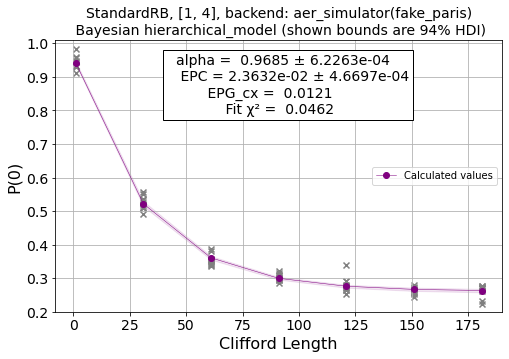

In [153]:
title = experiment_type +', ' + interleaved_gate\
          + str(physical_qubits)\
          +', backend: '+backend.name()+\
          "\n Bayesian "+model+" "+ bounds_rmk
bf.gsp_plot(scale, lengths, num_samples, shots, texto, title,
         y1, y1_min, y1_max, y2=None, y2_min=None, y2_max=None, Y1=Y, Y2=None,
         first_curve = "Calculated values", second_curve = None)

#### compare with frequentist model results

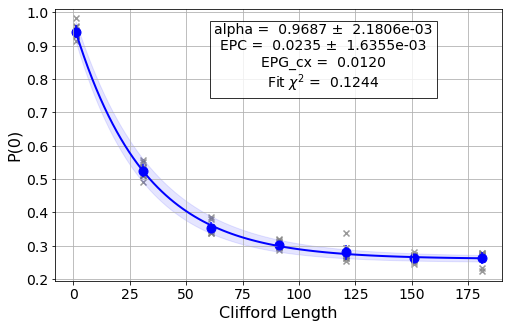

In [140]:
# View result data for frequentist model
display(expdata2.figure(0))